In [1]:
-- Torch packages
require 'image'
require 'cunn'
require 'cudnn'
require 'colormap'


In [2]:
opt = {
  input='frankfurt_000000_001236_leftImg8bit.png',
  imWidth='640',
  imHeight='320',
  devid = -1,
  net='../model-best.net',
}

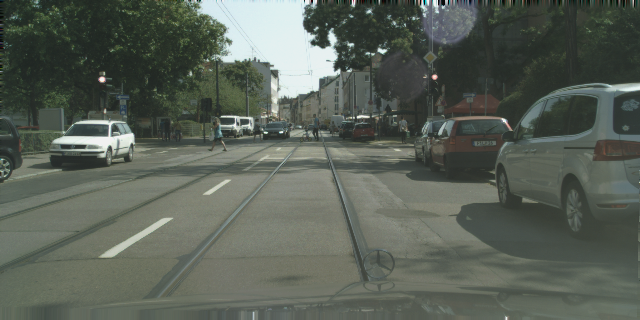

In [3]:
tmp = image.load(opt.input)
img = image.scale(tmp, opt.imWidth, opt.imHeight, 'bicubic')
itorch.image(img)

In [4]:
img[1][1][1]

0	


In [5]:
----------------------------------------
-- Network
network = {}
network.path = opt.net
assert(paths.filep(network.path), 'Model not present at ' .. network.path)
print("Loading model from: " .. network.path)

network.model = torch.load(network.path)

Loading model from: ../model-best.net	


In [6]:
torch.setdefaulttensortype('torch.FloatTensor')
if opt.devid > 0 then
   cutorch.setDevice(opt.devid)
   print("GPU # " .. cutorch.getDevice() .. " selected")
else
  print("CPU mode")
end

CPU mode	


In [7]:
-- Convert all the modules in nn from cudnn
if #network.model:findModules('cudnn.SpatialConvolution') > 0 then
   if network.model.__typename == 'nn.DataParallelTable' then
      network.model = network.model:get(1)
   end
end

-- Change model type based on device being used for demonstration
if opt.devid > 0 then
   network.model:cuda()
else
   cudnn.convert(network.model, nn)
   network.model:float()
end

-- Set the module mode 'train = false'
network.model:evaluate()
network.model:clearState()

In [8]:
tensor = torch.Tensor(1, 3, img:size(2), img:size(3))
tensor[1] = img

-- to GPU
if opt.devid > 0 then
  tensor = tensor:cuda()
end

In [9]:
timer = torch.Timer() -- the Timer starts to count now
-- compute network on frame:
distributions = network.model:forward(tensor):squeeze()
print('Time elapsed for forward: ' .. timer:time().real*1000 .. ' ms')

_, winners = distributions:max(1)

if opt.devid > 0 then
   cutorch.synchronize()
end
winner = winners:squeeze():float()

Time elapsed for forward: 874.2368221283 ms	


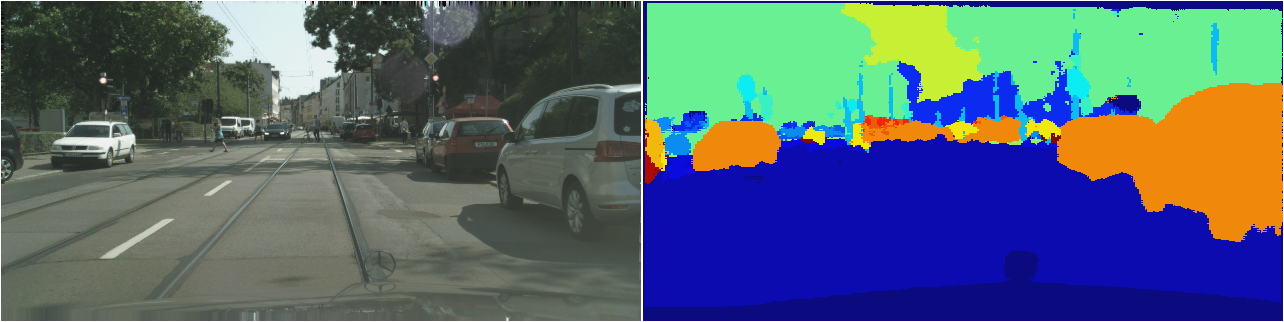

In [10]:
colormap:setStyle('jet')
label = colormap:convert(winner)
itorch.image({img, label})

In [11]:
-- image.save('result_torch.png', winner) don't do this
winner.libpng.save('result_torch_index.png', winner, 1)

In [12]:
'parula', 'autumn', 'hsv', 'hot', 'cool', 'winter', 'spring'

parula	autumn	hsv	hot	cool	winter	spring	
